# Classifying Coronavirus-Related Tweets Sentiment

- James M. Irving, Ph.D.
- 06/13/21

## TABLE OF CONTENTS 

*Click to jump to matching Markdown Header.*<br><br>

<font size=3rem>
    
- **[Introduction](#INTRODUCTION)<br>**
- **[OBTAIN](#OBTAIN)**<br>
- **[SCRUB](#SCRUB)**<br>
- **[EXPLORE](#EXPLORE)**<br>
- **[MODEL](#MODEL)**<br>
- **[iNTERPRET](#iNTERPRET)**<br>
- **[Conclusions/Recommendations](#CONCLUSIONS-&-RECOMMENDATIONS)<br>**
</font>
___

# INTRODUCTION

>- The Covid-19 pandemic has been an extreme moment in human history, in which the basic aspects of every day have been turned into complicated and risky endeavors. 
    - Understandably, the pandemic has generated a lot of strong feelings in individuals. 
    - These feelings can take on various forms: from frustration and anger to sadness and despair. 
    - Additionally, for many millen ials and Gen-Xers, the pandemic has actually been a postiive force in reducing social pressures.
    
    
> - For this analysis, we wanted to explore the nature of various sentiments related to Covid-19. Using covid-realated tweets from Kaggle, we will create a predictive model to predict the sentiment from the text. We will use these supervised learning models and additonal EDA to better understand the underlying reasons/motivations/issues for the various sentiments expressed. 

- Dataset from Kaggle:
    - https://www.kaggle.com/datatattle/covid-19-nlp-text-classification
- We will be using the `train.csv` dataset, which has been renamed to `cornavirus_tweets.csv.gz`

# OBTAIN

In [98]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import pandas as pd


from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import (CountVectorizer,TfidfTransformer, 
                                             TfidfVectorizer,ENGLISH_STOP_WORDS)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import nltk 
from nltk import TweetTokenizer, word_tokenize,wordpunct_tokenize
import string
from wordcloud import WordCloud



from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC



In [99]:
df = pd.read_csv("https://github.com/flatiron-school/Online-DS-FT-022221-Cohort-Notes/raw/master/Phase_4/topic_42_tuning_neural_networks/data/cornavirus_tweets.csv.gz",
                 encoding='latin-1',parse_dates=['TweetAt'])
df

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,2020-03-16,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,2020-03-16,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,2020-03-16,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,2020-03-16,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,2020-03-16,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...,...,...,...,...
41154,44951,89903,"Wellington City, New Zealand",2020-04-14,Airline pilots offering to stock supermarket s...,Neutral
41155,44952,89904,NaN,2020-04-14,Response to complaint not provided citing COVI...,Extremely Negative
41156,44953,89905,NaN,2020-04-14,You know itÃÂs getting tough when @KameronWi...,Positive
41157,44954,89906,NaN,2020-04-14,Is it wrong that the smell of hand sanitizer i...,Neutral


In [100]:
## SAMPLING FOR SG

df = df.sample(n=10000)

In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 5330 to 31464
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   UserName       10000 non-null  object        
 1   ScreenName     10000 non-null  object        
 2   Location       7889 non-null   object        
 3   TweetAt        10000 non-null  datetime64[ns]
 4   OriginalTweet  10000 non-null  object        
 5   Sentiment      10000 non-null  object        
dtypes: datetime64[ns](1), object(5)
memory usage: 546.9+ KB


## Data

- Columns of interest are:
    - For NLP classification:
        - Sentiment
        - OriginalTweet,
    - For EDA:
        - Sentiment
        - Location
        - TweetAt
        

# SCRUB

In [102]:
## Check for nulls
def null_check(df):
    """Returns a dataframe of null value counts andd %'s'"""
    nulls = df.isna().sum()
    return pd.DataFrame({'nulls':nulls,
                  '%null':nulls/len(df)*100}).round(2)
null_check(df)

,nulls,%null
UserName,0,0.00
ScreenName,0,0.00
Location,2111,21.11
TweetAt,0,0.00
OriginalTweet,0,0.00
Sentiment,0,0.00


- Drop nulls from subset=['OriginalTweet','Sentiment']
- Fill Nulls:
    - Location: "Unknown"

In [103]:
## deal with nulls and check
df['Location'].fillna('Unknown',inplace=True)
df.dropna(subset=['TweetAt','OriginalTweet','Sentiment'],inplace=True)

null_check(df)

,nulls,%null
UserName,0,0.0
ScreenName,0,0.0
Location,0,0.0
TweetAt,0,0.0
OriginalTweet,0,0.0
Sentiment,0,0.0


# EXPLORE

### Resources
- https://towardsdatascience.com/nlp-part-3-exploratory-data-analysis-of-text-data-1caa8ab3f79d

In [104]:
## How many unique users?
df['UserName'].nunique()

10000

In [105]:
## Are any users represented more than once?
user_counts = df["UserName"].value_counts()
user_counts[user_counts >1]

Series([], Name: UserName, dtype: int64)

## Exploring Sentiment

In [106]:
df['Sentiment'].unique()

array(['Neutral', 'Positive', 'Extremely Positive', 'Negative',
       'Extremely Negative'], dtype=object)

In [107]:
## Make list of sentiments for ordering plots 
sentiment_order = ['Extremely Negative', 'Negative','Neutral',
                   'Positive','Extremely Positive']

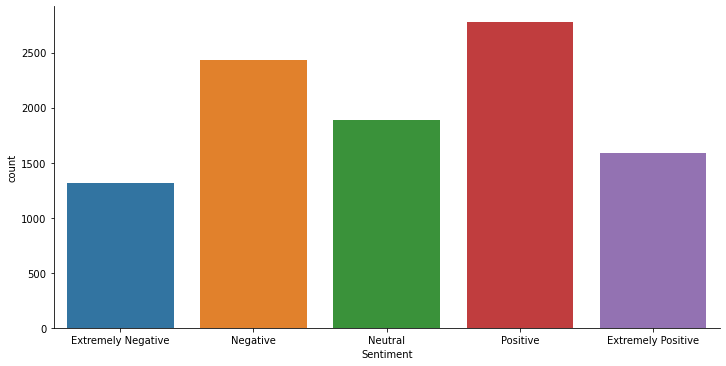

In [108]:
## Overall sentiment distribution
sns.catplot(data=df,x='Sentiment',kind='count',order=sentiment_order,aspect=2)

In [109]:
df['Sentiment'].value_counts(1)

Positive              0.2781
Negative              0.2431
Neutral               0.1886
Extremely Positive    0.1589
Extremely Negative    0.1313
Name: Sentiment, dtype: float64

>- The dataset has 5 sentiment ratings ranging from Extremely Negative to Extremely Positive. 
    - The classes are approximately balanced, but The Extreme sentiments and Neutral sentiments have fewer obserations

### Making a SimpleSentiment column as a 3-class column

In [110]:
simple_sentiment_mapper = {'Extremely Negative':"Negative",
                            'Negative':'Negative',
                            'Neutral':'Neutral',
                            'Positive':'Positive',
                            'Extremely Positive':'Positive'}
df['SimpleSentiment'] = df["Sentiment"].replace(simple_sentiment_mapper)
df["SimpleSentiment"].value_counts(1,dropna=False)

Positive    0.4370
Negative    0.3744
Neutral     0.1886
Name: SimpleSentiment, dtype: float64

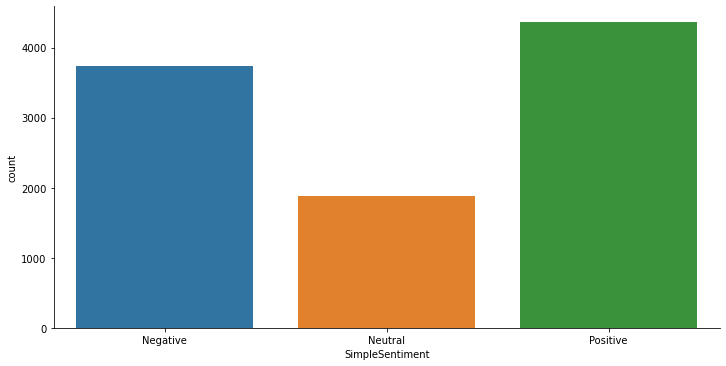

In [111]:
## Overall sentiment distribution
sns.catplot(data=df,x='SimpleSentiment',kind='count',
            order=['Negative','Neutral','Positive'],aspect=2)

> The simpler 3 class version of Sentiment creates a class imbalance issue with neutral tweets having the fewest observations.

## Exploring Location

In [112]:
## How many locations?
location_counts = df['Location'].value_counts()
location_counts.head(40)

Unknown                    2113
London                      142
London, England             118
United States               110
Washington, DC               94
New York, NY                 89
United Kingdom               81
India                        63
UK                           60
USA                          59
Los Angeles, CA              58
Australia                    56
Canada                       54
England, United Kingdom      45
Global                       44
Boston, MA                   41
Toronto, Ontario             38
Atlanta, GA                  37
Chicago, IL                  34
San Francisco, CA            34
New Delhi, India             33
California, USA              33
Worldwide                    31
New York, USA                29
Texas, USA                   28
New York City                27
Florida, USA                 25
Austin, TX                   25
New York                     24
Lagos, Nigeria               24
London, UK                   23
Mumbai, 

> - Will analyze locations with more than 100 tweets.

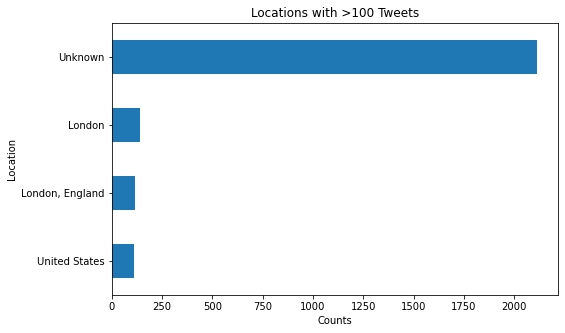

In [113]:
## Visualize locations with >100 tweets
frequent_locations = location_counts[(location_counts>100)&(location_counts<6000)]
ax = frequent_locations.sort_values().plot(kind='barh',figsize=(8,5))
ax.set(xlabel='Counts',ylabel='Location',title='Locations with >100 Tweets');

In [114]:
## Saving just most frequent locations
df_freq_location = df[df['Location'].isin(frequent_locations.index)]
df_freq_location

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,SimpleSentiment
5330,9129,54081,Unknown,2020-03-18,@rapplerdotcom @ABSCBNNews @DtiPhilippines @Ro...,Neutral,Neutral
16802,20601,65553,Unknown,2020-03-22,@PMOIndia DHROA thanks our PM for taking extra...,Positive,Positive
7172,10971,55923,Unknown,2020-03-19,I wore my #AirTamer personal air purifier and ...,Neutral,Neutral
24202,28001,72953,Unknown,2020-03-26,Yup Modi Govt is so beautiful that it increase...,Positive,Positive
24641,28440,73392,Unknown,2020-03-27,@miriamcosic @woolworths @hamishNews Yes Wooli...,Extremely Positive,Positive
...,...,...,...,...,...,...,...
10913,14712,59664,Unknown,2020-03-20,If you want to buy a devics with @TelkomZA don...,Positive,Positive
222,4021,48973,London,2020-03-16,UK consumers are already making small but sign...,Positive,Positive
34385,38183,83135,Unknown,2020-08-04,Federal Government: COVID-19 is a highly conta...,Negative,Negative
13735,17534,62486,London,2020-03-21,They say that gloves and a face mask are adequ...,Positive,Positive


### Sentiment Word Usage

In [115]:
## save a dictionary with each sentiment's df saved under the sentiment type
sent_dict = {}
for sentiment in df["SimpleSentiment"].unique():
    
    sent_dict[sentiment] = df[ df['Sentiment']==sentiment]
    
sent_dict.keys()

dict_keys(['Neutral', 'Positive', 'Negative'])

In [116]:
tokenizer = TweetTokenizer(preserve_case=False)

In [117]:
## save stopwords
stopwords_list = nltk.corpus.stopwords.words('english')
stopwords_list.extend(string.punctuation)
stopwords_list.extend(['http','https','co'])

covid_stopwords = [*stopwords_list, 'coronavirus','covid',
                  'covid19','covid_19','covid2019',"#coronavirus",
                  "#covid_19",'']

In [118]:
def prep_wordcloud_corpus(df,stopwords_list,text_col='OriginalTweet'):
    ## save neg_corpus and remove stopwords
    corpus = tokenizer.tokenize(' '.join(df[text_col]))
    corpus = [w.encode('ascii','ignore').decode() for w in corpus if w not in stopwords_list]
    return corpus


corpus_dict = {sentiment:prep_wordcloud_corpus(sents,covid_stopwords) for sentiment,sents \
                                                       in sent_dict.items()}
# neg_corpus = prep_wordcloud_corpus(neg_sents)
# pos_corpus = prep_wordcloud_corpus(pos_sents)
# neut_corpus = prep_wordcloud_corpus(neu_sents)
corpus_dict['Negative'][:5]

['week', 'starts', 'somber', 'note', 'reality']

[Text(0.5, 1.0, '25 Most Common Words in Negative Tweets')]

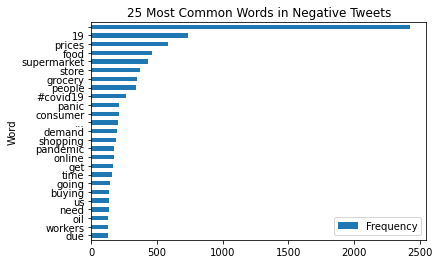

In [119]:
## MOST FREQUENT NEGATIVE TWEET WORDS
neg_freq = nltk.FreqDist(corpus_dict['Negative'])
neg_freq_df = pd.DataFrame(neg_freq.most_common(25),columns=['Word','Frequency'])
ax = neg_freq_df.set_index('Word').sort_values('Frequency').plot(kind='barh')
ax.set(title="25 Most Common Words in Negative Tweets")


[Text(0.5, 1.0, '25 Most Common Words in Positive Tweets')]

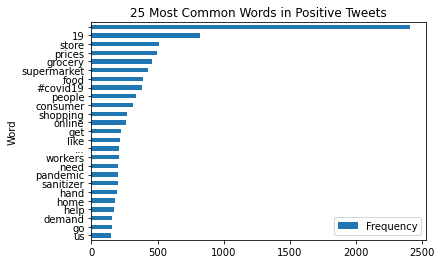

In [120]:
## MOST FREQUENT NEGATIVE TWEET WORDS

pos_freq = nltk.FreqDist(corpus_dict['Positive'])
pos_freq_df = pd.DataFrame(pos_freq.most_common(25),columns=['Word','Frequency'])
ax = pos_freq_df.set_index('Word').sort_values('Frequency').plot(kind='barh')
ax.set(title="25 Most Common Words in Positive Tweets")



### Comparing All 3 Sentiments Word Frequencies via WordClouds

In [121]:

### Specify params for all 3 word clouds
cloud_stopwords = [*stopwords_list, 'coronavirus','covid',
                  'covid19','covid_19','covid2019']
cloud_kws = dict(collocations=False,normalize_plurals=False,
                          stopwords=cloud_stopwords,
                          width=1200,min_word_length=2,
                          height=800,min_font_size=10)


## Tweaking final params aand generating clouds
wordcloud_dict = {}

wordcloud_dict['Negative']  = WordCloud(**cloud_kws,
                                        colormap='Reds'
                                       ).generate(' '.join(corpus_dict['Negative']))

wordcloud_dict['Neutral']  = WordCloud(**cloud_kws,
                                        colormap='Greys'
                                       ).generate(' '.join(corpus_dict['Neutral']))

wordcloud_dict['Positive']  = WordCloud(**cloud_kws,
                                        colormap='Greens'
                                       ).generate(' '.join(corpus_dict['Positive']))


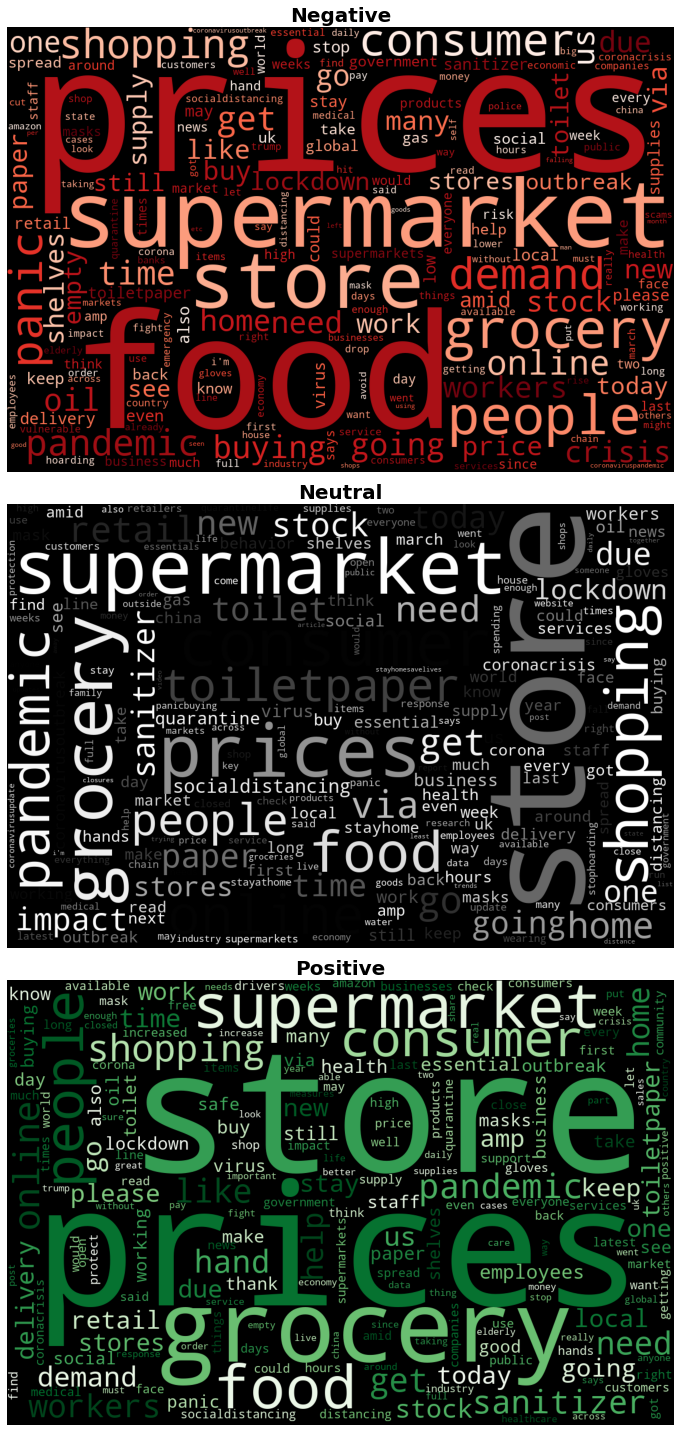

In [122]:
## Plot all 3 classes
fig, ax = plt.subplots(nrows=len(wordcloud_dict.keys()), figsize=(16,20))

title_font = {'fontweight':'bold','fontsize':20}
cmap_list = ['Reds','Greens','Greys']

i=0
for sentiment, cloud in wordcloud_dict.items():
    ax[i].imshow(cloud)
    ax[i].set_title(sentiment,fontdict=title_font)
    ax[i].axis('off')
    i+=1
    
plt.tight_layout()

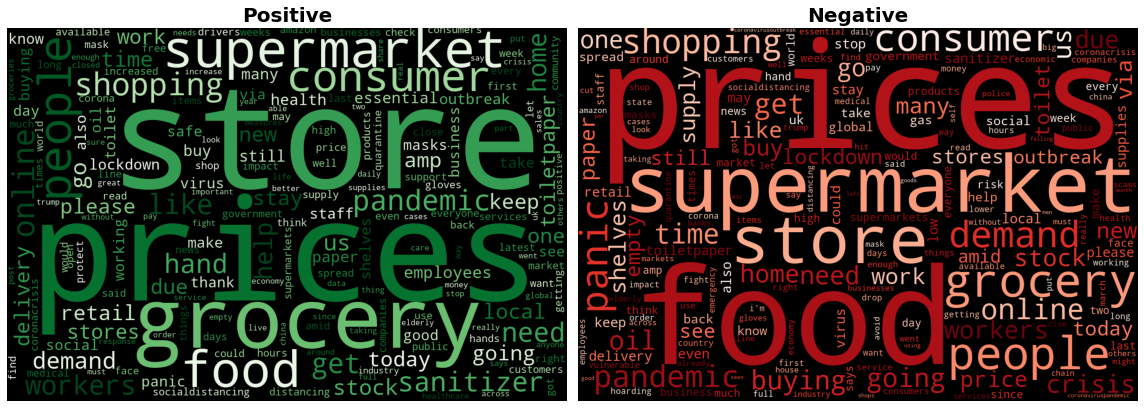

In [123]:
## Plot pos and neg side by side
fig, ax = plt.subplots(ncols=2, figsize=(16,20))

title_font = {'fontweight':'bold','fontsize':20}

sentiment = 'Positive'
ax[0].imshow(wordcloud_dict[sentiment])
ax[0].set_title(sentiment,fontdict=title_font)
ax[0].axis('off')

sentiment = 'Negative'

ax[1].imshow(wordcloud_dict[sentiment])
ax[1].set_title(sentiment,fontdict=title_font)
ax[1].axis('off')
plt.tight_layout()

# MODEL

## Make X,y + train_test_spit

In [124]:
## Make a dict mapper for target
target_map = dict(zip(sentiment_order,range(len(sentiment_order)+1)))
target_map

{'Extremely Negative': 0,
 'Negative': 1,
 'Neutral': 2,
 'Positive': 3,
 'Extremely Positive': 4}

In [125]:
## mapper for Simpler 3-class target
target_map_3class = {'Extremely Negative':0, 
                     'Negative':0,
                     'Neutral':1, 
                     'Positive':2,
                     'Extremely Positive':2}
target_map_3class

{'Extremely Negative': 0,
 'Negative': 0,
 'Neutral': 1,
 'Positive': 2,
 'Extremely Positive': 2}

In [126]:
## making numeric target col
df['target']=df['Sentiment'].map(target_map)
df['target'].value_counts(dropna=False,normalize=True)

3    0.2781
1    0.2431
2    0.1886
4    0.1589
0    0.1313
Name: target, dtype: float64

In [127]:
df['target_3class']=df['Sentiment'].map(target_map_3class)
df['target_3class'].value_counts(dropna=False,normalize=True)

2    0.4370
0    0.3744
1    0.1886
Name: target_3class, dtype: float64

In [128]:
X = df['OriginalTweet'].copy()
y = df['target_3class'].copy()#.map(target_map)
y.value_counts(1)

2    0.4370
0    0.3744
1    0.1886
Name: target_3class, dtype: float64

In [129]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.4,
                                                    random_state=321)


In [130]:
from sklearn import set_config
set_config(display='diagram')

In [131]:
## set up text preprocessing pipeline
tokenizer = TweetTokenizer(preserve_case=False,strip_handles=False)

text_pipe = Pipeline([
    ('vectorizer',CountVectorizer(strip_accents='unicode',
                                  tokenizer=tokenizer.tokenize,
                                 stop_words=stopwords_list)),
    ('tfidf',TfidfTransformer()) 
])
text_pipe

Pipeline(steps=[('vectorizer',
                 CountVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 strip_accents='unicode',
                                 tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x7fbdf690a040>>)),
                ('tfidf', TfidfTransformer())])

In [132]:
X_train_vec = text_pipe.fit_transform(X_train)
X_test_vec = text_pipe.transform(X_test)

In [133]:
X_train_vec

<6000x23368 sparse matrix of type '<class 'numpy.float64'>'
	with 113836 stored elements in Compressed Sparse Row format>

## TSNE 

In [134]:
from sklearn.manifold import TSNE
import plotly.express as px
from mpl_toolkits.mplot3d import Axes3D

In [140]:
## TSNE For Visualizing High Dimensional Data
t_sne_object_3d = TSNE(n_components=3,n_iter=500)
transformed_data_3d = t_sne_object_3d.fit_transform(X_train_vec)
transformed_data_3d

KeyboardInterrupt: 

In [ ]:
## Saving each sentiment as its own matrix for plotting
neg_tsne = transformed_data_3d[y_train==0]
neut_tsne = transformed_data_3d[y_train==1]
pos_tsne = transformed_data_3d[y_train==2]

In [ ]:
## Visualize TSNE
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(projection='3d')

ax.scatter(neg_tsne[:,0],neg_tsne[:,1],
           neg_tsne[:,2],c='red',label='Negative')

ax.scatter(pos_tsne[:,0],pos_tsne[:,1],
           pos_tsne[:,2],c='green',label='Positive')

ax.scatter(neut_tsne[:,0],neut_tsne[:,1],
           neut_tsne[:,2],c='gray',label='Neutral')


ax.legend()
# ax.view_init(30, 10)


fig.tight_layout()

### Latent Dirichilet Allocation

- https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html
- https://towardsdatascience.com/nlp-part-3-exploratory-data-analysis-of-text-data-1caa8ab3f79d

In [142]:
from sklearn.decomposition import LatentDirichletAllocation 
lda = LatentDirichletAllocation(n_components=5,verbose=1,random_state=0)
lda.fit(X_train_vec)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


LatentDirichletAllocation(n_components=5, random_state=0, verbose=1)

### PyLDAvis

- https://neptune.ai/blog/pyldavis-topic-modelling-exploration-tool-that-every-nlp-data-scientist-should-know
- https://github.com/bmabey/pyLDAvis
- https://nbviewer.jupyter.org/github/bmabey/pyLDAvis/blob/master/notebooks/sklearn.ipynb

In [149]:
# !pip install pyldavis

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [150]:
import pyLDAvis
import pyLDAvis.sklearn as lda_sk
pyLDAvis.enable_notebook()

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [152]:
lda_sk.prepare(lda,X_train_vec,text_pipe['vectorizer'])

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.032652  0.011792       1        1  20.749481
2      0.001530 -0.027628       2        1  20.453730
0      0.003747  0.014481       3        1  20.395355
4      0.003105 -0.016072       4        1  19.427582
1      0.024270  0.017427       5        1  18.973851, topic_info=           Term       Freq      Total Category  logprob  loglift
23344           75.000000  75.000000  Default  30.0000  30.0000
4309          7   4.000000   4.000000  Default  29.0000  29.0000
17959     nurse   3.000000   3.000000  Default  28.0000  28.0000
21085   special   4.000000   4.000000  Default  27.0000  27.0000
23349           12.000000  12.000000  Default  26.0000  26.0000
...         ...        ...        ...      ...      ...      ...
11403       get   4.617884  29.572614   Topic5  -6.9042  -0.1948
17767      need   4.395583  29.558212   Topic5  -6.9536  -0.2437
12006      home   4.101973  24.330672   Topic5  -7.0227  -0.1182
20702  shopping   4.405971  36.395341   Topic5  -6.9512  -0.4494
18100    online   4.155768  34.264495   Topic5  -7.0097  -0.4475

[433 rows x 6 columns], token_table=       Topic      Freq          Term
term                                
56         5  0.951620  #afghanistan
180        2  0.575107    #australia
219        1  1.018647    #bangalore
555        3  0.991276           #co
681        1  0.208979  #coronavirus
...      ...       ...           ...
23350      4  0.083885             
23350      5  0.251654             
23352      1  0.213665             
23352      2  0.213665             
23352      5  0.427330             

[742 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 1, 5, 2])

In [148]:
# app = pyLDAvis.prepare(lda, X_train_vec, text_pipe)#, mds='tsne')
# app

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Model Evaluation Functions

In [47]:
def evaluate_classification(model, X_test_tf,y_test,cmap='Greens',
                            normalize='true',classes=None,figsize=(10,4),
                            X_train = None, y_train = None,):
    """Evaluates a scikit-learn binary classification model.

    Args:
        model (classifier): any sklearn classification model.
        X_test_tf (Frame or Array): X data
        y_test (Series or Array): y data
        cmap (str, optional): Colormap for confusion matrix. Defaults to 'Greens'.
        normalize (str, optional): normalize argument for plot_confusion_matrix. 
                                    Defaults to 'true'.
        classes (list, optional): List of class names for display. Defaults to None.
        figsize (tuple, optional): figure size Defaults to (8,4).
        
        X_train (Frame or Array, optional): If provided, compare model.score 
                                for train and test. Defaults to None.
        y_train (Series or Array, optional): If provided, compare model.score 
                                for train and test. Defaults to None.
    """
    
    ## Get Predictions and Classification Report
    y_hat_test = model.predict(X_test_tf)
    print(metrics.classification_report(y_test, y_hat_test,target_names=classes))
    
    ## Plot Confusion Matrid and roc curve
    fig,ax = plt.subplots(ncols=2, figsize=figsize)
    metrics.plot_confusion_matrix(model, X_test_tf,y_test,cmap=cmap, 
                                  normalize=normalize,display_labels=classes,
                                 ax=ax[0])
    
    ## if roc curve erorrs, delete second ax
    try:
        curve = metrics.plot_roc_curve(model,X_test_tf,y_test,ax=ax[1])
        curve.ax_.grid()
        curve.ax_.plot([0,1],[0,1],ls=':')
        fig.tight_layout()
    except:
        fig.delaxes(ax[1])
    plt.show()
    
    ## Add comparing Scores if X_train and y_train provided.
    if (X_train is not None) & (y_train is not None):
        print(f"Training Score = {model.score(X_train,y_train):.2f}")
        print(f"Test Score = {model.score(X_test_tf,y_test):.2f}")
        
        

    
def plot_importance(tree, X_train_df, top_n=20,figsize=(10,10)):
    
    df_importance = pd.Series(tree.feature_importances_,
                              index=X_train_df.columns)
    df_importance.sort_values(ascending=True).tail(top_n).plot(
        kind='barh',figsize=figsize,title='Feature Importances',
    ylabel='Feature',)
    return df_importance



## Modeling Logistics

1. Use the same variable name for each of the types of models to fit to save memory. 
2. After evaluating, save the model with joblib as f"last_{model type}.joblib"

3. Load up the models after training if want to get insights or compare.

In [48]:
import os,joblib
save_path = "./models/"
os.makedirs(save_path, exist_ok=True)
sorted(os.listdir(save_path))

['gridsearch_log_reg.joblib',
 'gridsearch_random_forest.joblib',
 'log_reg_best_C.joblib',
 'log_reg_ce12.joblib',
 'log_reg_cv.joblib',
 'naive_bayes.joblib',
 'random_forest.joblib',
 'svc_linear.joblib']

## Model 1: LogisticRegression

In [49]:
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn import metrics

### Vanilla LogReg, no regularization

In [52]:
y_train.value_counts(1).sort_index()

0    0.371153
1    0.187844
2    0.441003
Name: target_3class, dtype: float64

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='target_3class', ylabel='count'>

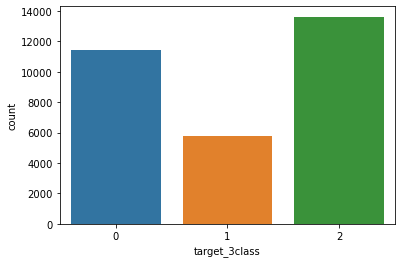

In [51]:
sns.countplot(y_train)

              precision    recall  f1-score   support

           0       0.78      0.78      0.78      3942
           1       0.63      0.55      0.58      1913
           2       0.78      0.83      0.81      4434

    accuracy                           0.76     10289
   macro avg       0.73      0.72      0.72     10289
weighted avg       0.75      0.76      0.76     10289



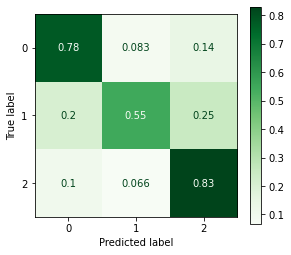

Training Score = 1.00
Test Score = 0.76


['./models/log_reg_ce12.joblib']

In [53]:
## Log reg- not using classweight
clf = LogisticRegression(C=1e12, max_iter=300)
clf.fit(X_train_vec,y_train)
evaluate_classification(clf,X_test_vec, y_test,X_train = X_train_vec,y_train=y_train)

joblib.dump(clf, f"{save_path}log_reg_ce12.joblib")

              precision    recall  f1-score   support

           0       0.78      0.78      0.78      3942
           1       0.64      0.56      0.60      1913
           2       0.78      0.82      0.80      4434

    accuracy                           0.76     10289
   macro avg       0.73      0.72      0.73     10289
weighted avg       0.75      0.76      0.76     10289



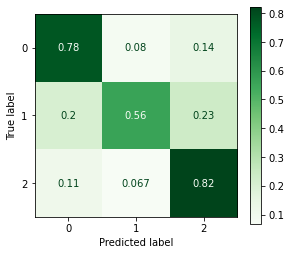

Training Score = 1.00
Test Score = 0.76


['./models/log_reg_ce12.joblib']

In [54]:
clf = LogisticRegression(C=1e12,class_weight='balanced', max_iter=300)
clf.fit(X_train_vec,y_train)
evaluate_classification(clf,X_test_vec, y_test,X_train = X_train_vec,y_train=y_train)

joblib.dump(clf, f"{save_path}log_reg_ce12.joblib")

### GridSearch for C

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.5min finished


              precision    recall  f1-score   support

           0       0.83      0.78      0.80      3942
           1       0.62      0.75      0.68      1913
           2       0.85      0.81      0.83      4434

    accuracy                           0.79     10289
   macro avg       0.76      0.78      0.77     10289
weighted avg       0.80      0.79      0.79     10289



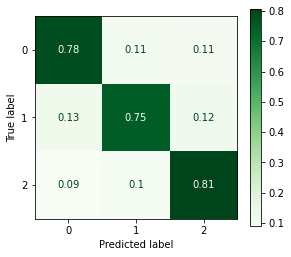

Training Score = 0.96
Test Score = 0.78
[2.7825594 2.7825594 2.7825594]


['./models/log_reg_cv.joblib']

In [55]:
clf = LogisticRegressionCV(class_weight='balanced',max_iter=300,cv=3,
                           scoring='recall_macro',n_jobs=-1,verbose=2)
clf.fit(X_train_vec,y_train)
evaluate_classification(clf,X_test_vec,y_test,X_train = X_train_vec,y_train=y_train)

print(clf.C_)
joblib.dump(clf, f"{save_path}log_reg_cv.joblib")

              precision    recall  f1-score   support

           0       0.83      0.78      0.80      3942
           1       0.62      0.75      0.68      1913
           2       0.85      0.81      0.83      4434

    accuracy                           0.79     10289
   macro avg       0.76      0.78      0.77     10289
weighted avg       0.80      0.79      0.79     10289



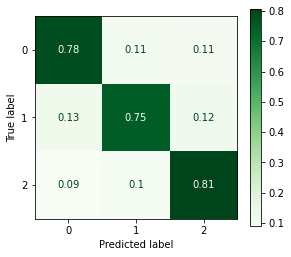

Training Score = 0.96
Test Score = 0.79


['./models/log_reg_best_C.joblib']

In [56]:
best_C = 2.7825594
clf = LogisticRegression(C=best_C,class_weight='balanced', max_iter=300)
clf.fit(X_train_vec,y_train)
evaluate_classification(clf,X_test_vec,y_test,X_train = X_train_vec,y_train=y_train)
joblib.dump(clf,f"{save_path}log_reg_best_C.joblib")

### LogReg Full GridSearch

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  3.3min finished


{'C': 3, 'penalty': 'l1'}
              precision    recall  f1-score   support

           0       0.88      0.82      0.85      3942
           1       0.69      0.85      0.76      1913
           2       0.89      0.85      0.87      4434

    accuracy                           0.84     10289
   macro avg       0.82      0.84      0.83     10289
weighted avg       0.85      0.84      0.84     10289



/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


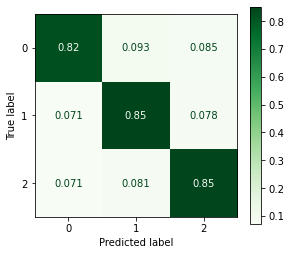

Training Score = 0.91
Test Score = 0.84


['./models/gridsearch_log_reg.joblib']

In [57]:
## logreg gridsearch

clf = LogisticRegression(class_weight='balanced',solver='saga')

params = {'C':[1.0,3,10],
          'penalty':['elasticnet','l2','l1']
         }

gridsearch = GridSearchCV(clf,params,cv=3, scoring='recall_macro',
                          verbose=True, n_jobs=-1)

gridsearch.fit(X_train_vec,y_train)
print(gridsearch.best_params_)

evaluate_classification(gridsearch.best_estimator_, X_test_vec,y_test,
                        X_train = X_train_vec,y_train=y_train)

joblib.dump(gridsearch.best_estimator_,f"{save_path}gridsearch_log_reg.joblib")

### LogReg+Text Pipe GridSearch

In [58]:
## set up text preprocessing pipeline
tokenizer = TweetTokenizer(preserve_case=False,strip_handles=False)
text_pipe = Pipeline([
    ('vectorizer',CountVectorizer(strip_accents='unicode',
                                  tokenizer=tokenizer.tokenize,
                                 stop_words=None)),#=stopwords_list)),
    ('tfidf',TfidfTransformer()) 
])
    
    
full_pipe = Pipeline([
    ('text',text_pipe),
    ('clf',LogisticRegression(class_weight='balanced',solver='saga'))
])

full_pipe

Pipeline(steps=[('text',
                 Pipeline(steps=[('vectorizer',
                                  CountVectorizer(strip_accents='unicode',
                                                  tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x7faca14c2b80>>)),
                                 ('tfidf', TfidfTransformer())])),
                ('clf',
                 LogisticRegression(class_weight='balanced', solver='saga'))])

In [62]:
## Checking params for text
full_pipe.named_steps['text'].named_steps['vectorizer']

CountVectorizer(strip_accents='unicode',
                tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x7faca14c2b80>>)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   35.4s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  1.3min finished


{'clf__C': 5, 'clf__solver': 'saga', 'text__vectorizer__stop_words': None}
              precision    recall  f1-score   support

           0       0.84      0.81      0.82      3942
           1       0.65      0.74      0.69      1913
           2       0.84      0.83      0.84      4434

    accuracy                           0.80     10289
   macro avg       0.78      0.79      0.78     10289
weighted avg       0.81      0.80      0.80     10289



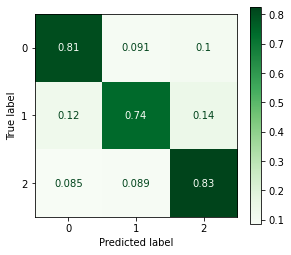

Training Score = 0.98
Test Score = 0.80


['./models/gridsearch_log_reg.joblib']

In [63]:
## logreg gridsearch
# clf = LogisticRegression(class_weight='balanced',solver='saga')
full_pipe.named_steps['clf'] = LogisticRegression(class_weight='balanced',penalty='l1',
                                      solver='sag')
params = {'clf__C':[1,3,5,10],
          'clf__solver':['saga','sag'],
          'text__vectorizer__stop_words':[None, stopwords_list],
#           'text__vectorizer'
         }

gridsearch = GridSearchCV(full_pipe,params,cv=3, scoring='f1_macro',
                          verbose=2, n_jobs=-1)

gridsearch.fit(X_train,y_train)
print(gridsearch.best_params_)

evaluate_classification(gridsearch.best_estimator_, X_test,y_test,
                        X_train = X_train,y_train=y_train)

joblib.dump(gridsearch.best_estimator_,f"{save_path}gridsearch_log_reg.joblib")

## RandomForest

              precision    recall  f1-score   support

           0       0.76      0.69      0.72      3942
           1       0.61      0.66      0.63      1913
           2       0.75      0.79      0.77      4434

    accuracy                           0.73     10289
   macro avg       0.71      0.71      0.71     10289
weighted avg       0.73      0.73      0.73     10289



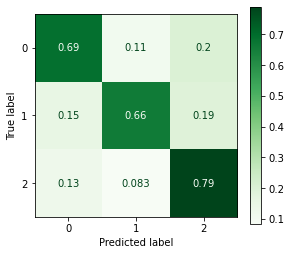

Training Score = 1.00
Test Score = 0.73


['./models/random_forest.joblib']

In [65]:
clf = RandomForestClassifier(class_weight='balanced')
clf.fit(X_train_vec,y_train)

evaluate_classification(clf,X_test_vec,y_test,
                        X_train = X_train_vec, y_train=y_train)

joblib.dump(clf,f"{save_path}random_forest.joblib",compress=3)

<AxesSubplot:ylabel='Count'>

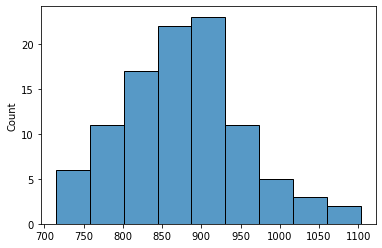

In [66]:
## Checking depths of rf trees
depths = [tree.get_depth() for tree in clf.estimators_]
sns.histplot(depths)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:  3.5min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  3.6min finished


{'max_depth': 500}
              precision    recall  f1-score   support

           0       0.77      0.68      0.72      3942
           1       0.61      0.67      0.64      1913
           2       0.75      0.79      0.77      4434

    accuracy                           0.73     10289
   macro avg       0.71      0.71      0.71     10289
weighted avg       0.73      0.73      0.73     10289



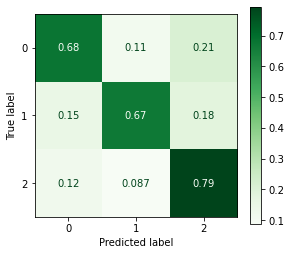

Training Score = 1.00
Test Score = 0.73


['./models/gridsearch_random_forest.joblib']

In [67]:
## rf gridsearch

clf = RandomForestClassifier(class_weight='balanced')

params = {'max_depth':[400,500,600]
         }

gridsearch = GridSearchCV(clf,params,cv=3, scoring='recall_macro',verbose=True, 
                          n_jobs=-1)

gridsearch.fit(X_train_vec,y_train)
print(gridsearch.best_params_)
evaluate_classification(gridsearch.best_estimator_, X_test_vec,y_test,X_train = X_train_vec,y_train=y_train)
joblib.dump(gridsearch.best_estimator_,f"{save_path}gridsearch_random_forest.joblib",compress=3)

In [69]:
gridsearch.best_params_

{'max_depth': 500}

In [70]:
pd.DataFrame(gridsearch.cv_results_).set_index('param_max_depth')['mean_test_score']

param_max_depth
400    0.699495
500    0.700621
600    0.696691
Name: mean_test_score, dtype: float64

### Naive Bayes

In [71]:
from sklearn.naive_bayes import MultinomialNB

              precision    recall  f1-score   support

           0       0.72      0.66      0.69      3942
           1       0.81      0.08      0.15      1913
           2       0.61      0.89      0.72      4434

    accuracy                           0.65     10289
   macro avg       0.71      0.54      0.52     10289
weighted avg       0.69      0.65      0.60     10289



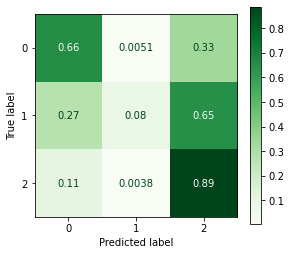

Training Score = 0.81
Test Score = 0.65


['./models/naive_bayes.joblib']

In [72]:
clf = MultinomialNB(fit_prior=False)#class_weight='balanced')
clf.fit(X_train_vec,y_train)
evaluate_classification(clf,X_test_vec,y_test,X_train = X_train_vec,y_train=y_train)
joblib.dump(clf,f"{save_path}naive_bayes.joblib")

### LinearSVC

In [73]:
# raise Exception('Check SVC parms before running!')

[LibSVM]              precision    recall  f1-score   support

           0       0.81      0.79      0.80      3942
           1       0.64      0.76      0.69      1913
           2       0.85      0.80      0.83      4434

    accuracy                           0.79     10289
   macro avg       0.77      0.78      0.77     10289
weighted avg       0.80      0.79      0.79     10289



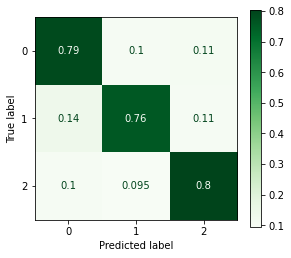

Training Score = 0.93
Test Score = 0.79


In [74]:
clf = SVC(kernel='linear',class_weight='balanced',verbose=2)
clf.fit(X_train_vec,y_train)
evaluate_classification(clf,X_test_vec,y_test,X_train = X_train_vec,y_train=y_train)

In [75]:
joblib.dump(clf,f"{save_path}svc_linear.joblib")

['./models/svc_linear.joblib']

# iNTERPRET

## Testing Loading Models

In [76]:
model = joblib.load(f"{save_path}random_forest.joblib")
model

RandomForestClassifier(class_weight='balanced')

In [77]:
text_pipe.named_steps['vectorizer'].get_feature_names()[:5]

NotFittedError: Vocabulary not fitted or provided

In [ ]:
importantces = pd.Series(model.feature_importances_, 
                         index=text_pipe.named_steps['vectorizer'].get_feature_names())
importantces.sort_values().tail(25).plot(kind='barh')

# CONCLUSIONS & RECOMMENDATIONS

> Summarize your conclusions and bullet-point your list of recommendations, which are based on your modeling results.

## Combining Spacy and Scattertext

- https://towardsdatascience.com/setting-up-text-preprocessing-pipeline-using-scikit-learn-and-spacy-e09b9b76758f

In [27]:
# # Visit https://spacy.io/usage for isntallation tool
# # !python -m spacy download en_core_web_sm
# import spacy
# nlp = spacy.load('en_core_web_sm')

In [28]:
# nlp.pipeline

In [29]:
# nlp.disable_pipes('tagger','ner')

In [30]:
# nlp.pipeline

In [31]:
#https://colab.research.google.com/github/DerwenAI/spaCy_tuTorial/blob/master/spaCy_tuTorial.ipynb#scrollTo=Bjz8pBV5D1r-
# !pip install scattertext

In [32]:
# df

In [33]:
# import scattertext as st
# st_corpus = st.CorpusFromPandas(df,
#                              category_col="SimpleSentiment",
#                              text_col="OriginalTweet",
#                              nlp=nlp).build()

In [34]:
# df[]

In [35]:
# st_html = st.produce_scattertext_explorer(
#     st_corpus,
#     category="Negative",
#     category_name="Negative Tweets",
#     not_category_name="Positive Tweets",
#     width_in_pixels=1000,
#     metadata=df[['Location','TweetAt']]#convention_df["speaker"]
# )

In [36]:
# from IPython.display import IFrame
# file_name = "scattertext_negative.html"

# with open(file_name, "wb") as f:
#     f.write(st_html.encode("utf-8"))

# # IFrame(src=file_name, width = 1200, height=700)